In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
sys.path.insert(1, "../python/functions")
sys.path.insert(2, "../python/architecture")

In [3]:
from data_prep_functions import wine_prep
from model_functions import *
from plotting_functions import *
import no_gpu
import reproducible
from sklearn.metrics import mean_squared_error

In [4]:
import time

In [5]:
X_train, X_test, y_train, y_test = wine_prep()

In [6]:
layers = 4
neurons = [32, 32, 16, 1]
n_cols = X_train.shape[1]
batch_size = 32
epochs = 10
optimizer = "adam"

Epoch 1/10
131/131 [==============================] - 0s 2ms/step - loss: 6.8256 - mse: 6.8256 - val_loss: 1.3411 - val_mse: 1.3411
Epoch 2/10
131/131 [==============================] - 0s 935us/step - loss: 1.2288 - mse: 1.2288 - val_loss: 0.8971 - val_mse: 0.8971
Epoch 3/10
131/131 [==============================] - 0s 2ms/step - loss: 0.8823 - mse: 0.8823 - val_loss: 0.7216 - val_mse: 0.7216
Epoch 4/10
131/131 [==============================] - 0s 1ms/step - loss: 0.6970 - mse: 0.6970 - val_loss: 0.6369 - val_mse: 0.6369
Epoch 5/10
131/131 [==============================] - 0s 1ms/step - loss: 0.6041 - mse: 0.6041 - val_loss: 0.5861 - val_mse: 0.5861
Epoch 6/10
131/131 [==============================] - 0s 1ms/step - loss: 0.5527 - mse: 0.5527 - val_loss: 0.5606 - val_mse: 0.5606
Epoch 7/10
131/131 [==============================] - 0s 1ms/step - loss: 0.5236 - mse: 0.5236 - val_loss: 0.5540 - val_mse: 0.5540
Epoch 8/10
131/131 [==============================] - 0s 1ms/step - loss: 

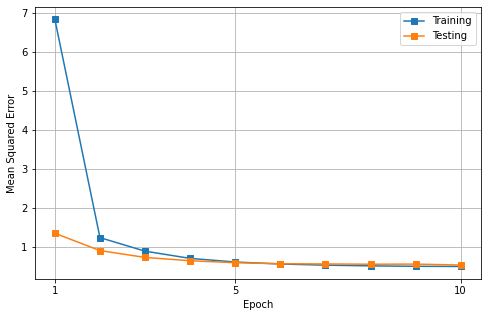

In [7]:
model = nn_model_structure(layers = layers,
                           neurons = neurons,
                           n_cols = n_cols,
                           classification = False)
model = nn_model_compile(model,
                         optimizer = optimizer)
start_time = time.time()
model = nn_model_fit(model,
                     X_train,
                     y_train,
                     X_val = X_test,
                     y_val = y_test,
                     batch_size = batch_size,
                     epochs = epochs)
end_time = time.time()
print("Overall calculation took {} seconds.".format(end_time - start_time))
model.summary()
nn_plot_mse(model,
            mse_mean = None)
nn_save(model,
        "../models/wine/wine_{}_E{}_B{}.h5".format(optimizer, epochs, batch_size))

In [8]:
model.history.history

{'loss': [6.825638294219971,
  1.2287912368774414,
  0.8822638988494873,
  0.6969601511955261,
  0.6041452884674072,
  0.5526803731918335,
  0.5235646367073059,
  0.5052669048309326,
  0.4939741790294647,
  0.49040770530700684],
 'mse': [6.825638294219971,
  1.2287912368774414,
  0.8822638988494873,
  0.6969601511955261,
  0.6041452884674072,
  0.5526803731918335,
  0.5235646367073059,
  0.5052669048309326,
  0.4939741790294647,
  0.49040770530700684],
 'val_loss': [1.3411308526992798,
  0.8971455693244934,
  0.7216396331787109,
  0.6368592381477356,
  0.5861184597015381,
  0.560566782951355,
  0.5540269017219543,
  0.546967625617981,
  0.5504664778709412,
  0.5257906317710876],
 'val_mse': [1.3411308526992798,
  0.8971455693244934,
  0.7216396331787109,
  0.6368592381477356,
  0.5861184597015381,
  0.560566782951355,
  0.5540269017219543,
  0.546967625617981,
  0.5504664778709412,
  0.5257906317710876]}

In [9]:
model.evaluate(X_test, y_test)

23/23 [==============================] - 0s 678us/step - loss: 0.5258 - mse: 0.5258


[0.5257906317710876, 0.5257906317710876]

In [10]:
y_true, y_pred = nn_mse_pred_true(model, X_test, y_test, print_comp = True)

Prediction: 6.66317892074585, Actual: 7
Prediction: 6.6838812828063965, Actual: 7
Prediction: 4.821372985839844, Actual: 5
Prediction: 5.437165260314941, Actual: 6
Prediction: 6.306534767150879, Actual: 6
Prediction: 5.957852840423584, Actual: 5
Prediction: 5.453202724456787, Actual: 7
Prediction: 4.721536159515381, Actual: 5
Prediction: 5.2744646072387695, Actual: 5
Prediction: 4.894833564758301, Actual: 4
Prediction: 5.22005558013916, Actual: 5
Prediction: 5.255832195281982, Actual: 5
Prediction: 5.288158893585205, Actual: 5
Prediction: 5.268518924713135, Actual: 5
Prediction: 4.753240585327148, Actual: 5
Prediction: 6.218936443328857, Actual: 6
Prediction: 5.4620890617370605, Actual: 6
Prediction: 6.236027240753174, Actual: 6
Prediction: 5.542374610900879, Actual: 5
Prediction: 4.937466144561768, Actual: 5
Prediction: 6.519871711730957, Actual: 6
Prediction: 7.005595684051514, Actual: 7
Prediction: 5.206773281097412, Actual: 5
Prediction: 5.8217573165893555, Actual: 8
Prediction: 6.

In [11]:
import numpy as np
y_pred_rounded = np.round(model.predict(X_test))

mse_prediction = mean_squared_error(y_test, y_pred_rounded)
mse_prediction

0.6326530612244898